In [1133]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [1134]:
# TODO: you will design your model here
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: implement this method
        super(SimpleModel,self).__init__()
        # Define architecture of NN
        # 3 linear layers with ReLU activation between them to solve vanishing gradient issues
        # 2 dropout layers to prevent overfitting
        # Adjust sizes as needed
        self.layer1 = nn.Linear(input_size, 128)  # First layer
        self.relu1 = nn.ReLU()  # intermediate ReLU
        self.dropout1 = nn.Dropout(0.5)  # Disregard nodes
        self.layer2 = nn.Linear(128, 64)  # Second layer
        self.relu2 = nn.ReLU()  # intermediate ReLU
        self.dropout2 = nn.Dropout(0.5)  # Disregard nodes
        self.layer3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)

        return x

In [1135]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    # Enter training mode
    model.train()
    
    # Move model to device
    model.to(device)
    
    # Transfer data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Forward pass: compute model output
    outputs = model(X_train)
    
    # Compute loss
    loss = loss_fn(outputs, y_train)
    
    # Backward pass
    loss.backward()
    
    # Perform 1 optimization
    optimizer.step()
    
    # Calc accuracy
    _, predicted = torch.max(outputs.data, 1)
    total = y_train.size(0)
    correct = (predicted == y_train).sum().item()
    accuracy = 100 * correct / total
    
    # Return loss and accuracy
    return loss.item(), accuracy

In [1136]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    # Enter eval mode
    model.eval()
    
    # Move model to device
    model.to(device)
    
    # Transfer data to device
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Disable gradient calc
    with torch.no_grad():
        # Forward pass: compute model output
        outputs = model(X_test)
        
        # Compute loss
        loss = loss_fn(outputs, y_test)
        
        # Calc accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = y_test.size(0)
        correct = (predicted == y_test).sum().item()
        accuracy = 100 * correct / total

    # Return loss and accuracy
    return loss.item(), accuracy

In [1137]:
def adjust_learning_rate(optimizer, epoch, initial_lr=0.0095, decay_rate=0.99):
    """ Adjusts learning rate based on epoch number """
    lr = initial_lr * (decay_rate ** epoch)
    for param_group in optimizer.parameters:
        param_group.lr = lr

class SimpleGradDescentOptimizer:
    """ This is a simple optimizer which provides functions for 
        optimization steps and zeroing out the gradient. """
    def __init__(self, parameters, lr=0.0095):
        self.parameters = list(parameters)
        self.lr = lr
    
    def step(self):
        """ Perform a single optimization step """
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param -= self.lr * param.grad
                    
    def zero_grad(self):
        """ Clear gradients of all optimized parameters """
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "cpu" 
    if torch.cuda.is_available(): 
       device = "cuda"
        
    # I removed this, it was giving me errors
    #else:
        #if torch.backends.mps.is_available():
            #device = "mps" 
    
    torch.manual_seed(random_seed) # do not change this
    
    # Model init
    input_size = X_train.shape[1]
    output_size = len(torch.unique(y_train))
    model = SimpleModel(input_size, output_size).to(device)
    
    # Loss fn
    loss_fn = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = SimpleGradDescentOptimizer(model.parameters(), lr=0.0095)
    
    # alpha
    lr = 0.0095
    
    # num epochs
    num_epochs = 500 # Number of epochs
    train_losses, train_accuracies = [], []  # Init to empty
    test_losses, test_accuracies = [], []  # Init to empty
    
    
    # Training loop
    for epoch in range(num_epochs):
        adjust_learning_rate(optimizer, epoch)
        model.train()  # Set to training
        #optimizer.zero_grad()  # Clear gradients
        
        # Forward step
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        
        loss.backward()  # backprop
        optimizer.step()  # Update weights

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = y_train.size(0)
        correct = (predicted == y_train).sum().item()
        train_accuracy = 100 * correct / total

        # Evaluation step on the train dataset
        train_loss, train_accuracy = evaluation_step(model, X_train, y_train, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation step on the test dataset
        test_loss, test_accuracy = evaluation_step(model, X_test, y_test, loss_fn, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [1138]:
def plot_accuracy_performance(train_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))  # make plt object
    epochs = range(1, len(train_accuracies) + 1)  # size of x
    
    # Plot training and test acc
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')  # y-axis for train set
    plt.plot(epochs, test_accuracies, 'ro-', label='Test Accuracy')  # y-axis for test set
    
    # Title and Labels
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # Legend
    plt.legend()
    plt.show()

In [1139]:
def plot_loss_performance(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_accuracies) + 1)  # size of x
    
    # Plot training and test acc
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')  # y-axis for train set
    plt.plot(epochs, test_losses, 'ro-', label='Test Loss')  # y-axis for test set
    
    # Title and Labels
    plt.title('Training and Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    
    # Legend
    plt.legend()
    plt.show()

In [1140]:
# TODO: plot decision boundary
def plot_decision_boundary(model, X_train, y_train):
    # Set min and max values and give it some padding
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    h = 0.01  # Step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    model.eval()  # Make sure model is in eval mode for inference
    with torch.no_grad():
        Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
        Z = Z.argmax(axis=1).numpy()
        Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary with the Training Set')
    plt.show()

In [1141]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

Epoch 1/500, Train Loss: 1.7246, Train Accuracy: 3.16%, Test Loss: 1.4299, Test Accuracy: 2.95%
Epoch 2/500, Train Loss: 1.6422, Train Accuracy: 18.49%, Test Loss: 1.3220, Test Accuracy: 18.75%
Epoch 3/500, Train Loss: 1.5057, Train Accuracy: 31.64%, Test Loss: 1.2347, Test Accuracy: 30.75%
Epoch 4/500, Train Loss: 1.4126, Train Accuracy: 36.73%, Test Loss: 1.1711, Test Accuracy: 36.15%
Epoch 5/500, Train Loss: 1.3133, Train Accuracy: 44.20%, Test Loss: 1.1040, Test Accuracy: 44.15%
Epoch 6/500, Train Loss: 1.2290, Train Accuracy: 50.60%, Test Loss: 1.0358, Test Accuracy: 49.25%
Epoch 7/500, Train Loss: 1.1387, Train Accuracy: 66.70%, Test Loss: 0.9618, Test Accuracy: 65.45%
Epoch 8/500, Train Loss: 1.0641, Train Accuracy: 63.15%, Test Loss: 0.8908, Test Accuracy: 61.65%
Epoch 9/500, Train Loss: 1.0013, Train Accuracy: 62.59%, Test Loss: 0.8310, Test Accuracy: 61.60%
Epoch 10/500, Train Loss: 0.9522, Train Accuracy: 67.35%, Test Loss: 0.7803, Test Accuracy: 67.70%
Epoch 11/500, Train L

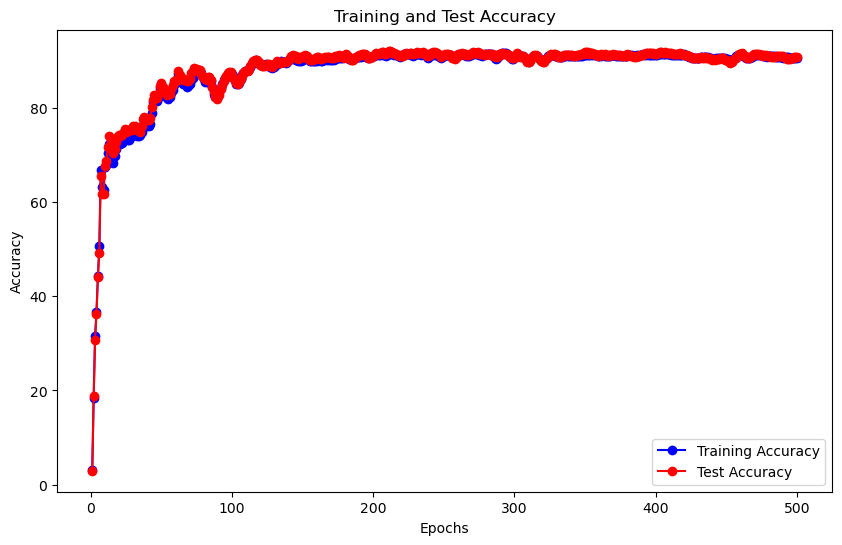

In [1142]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

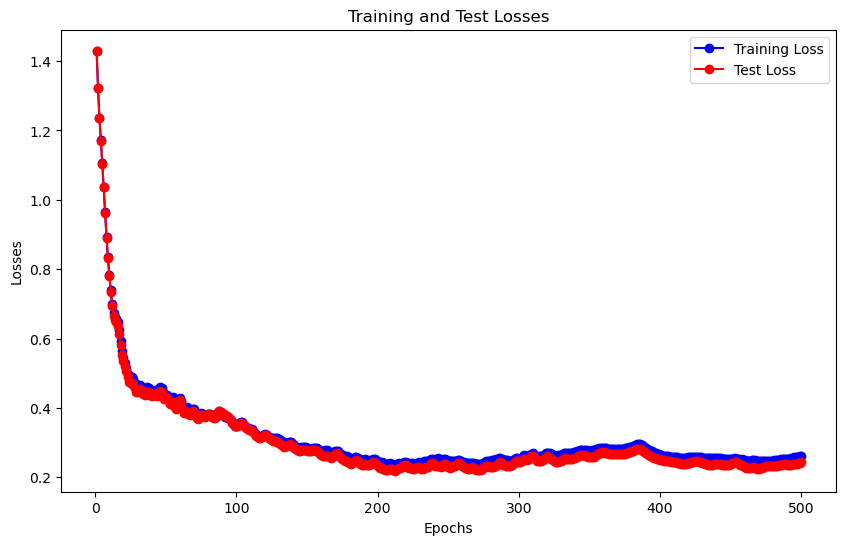

In [1143]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

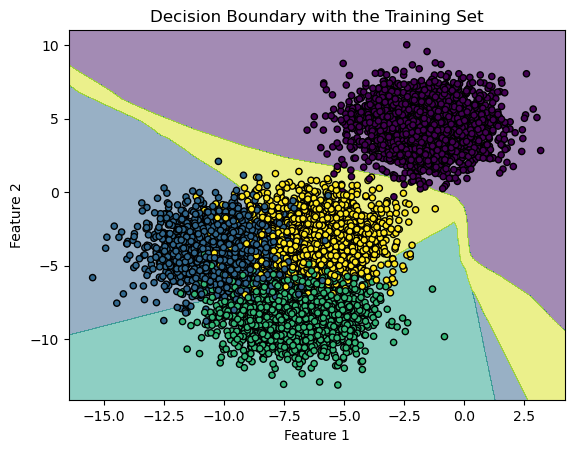

In [1144]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)